In [36]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
import ttools #homemade module
import gtfs #homemade module
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
%matplotlib inline

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('gtfs_subset/')
stops = gtfs.load_stops('gtfs_subset/')
stop_times, tz_sched = gtfs.load_stop_times('gtfs_subset/')
tcal = gtfs.TransitCalendar('gtfs_subset/')
print 'Finished loading GTFS data.'

Finished loading GTFS data.


# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('newdata_parsed.csv')#,parse_dates=dt_columns)
bustime.drop_duplicates(['vehicleID','RecordedAtTime'],inplace=True)
bustime['Trip'] = bustime['Trip'].str.replace('MTA NYCT_','')
bustime.set_index(['Line','Trip','TripDate','vehicleID','RecordedAtTime'],
                  inplace=True,drop=True,verify_integrity=True)

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/test2.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id','next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)#,verify_integrity=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# for demonstration, use a subset. Just get data for one line (M5) on one day.
tripDateLookup = "2015-01-06"
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
print 'Finished loading BusTime data and and slicing one day.'

Finished loading BusTime data and and slicing one day.


In [5]:
bustime['timestamp_hour'] = bustime['timestamp'].str[11:13]

In [6]:
bustime.groupby('timestamp_hour').size()

timestamp_hour
00     44315
01     20938
02     13868
03     12987
04     21359
05     54743
06     86121
07     45115
08     52033
09     94293
10    150900
11    131875
12    137770
13    124391
14     54107
15     28759
16     38179
17     42506
18     63992
19    108940
20    101036
21     87412
22     75087
23     58310
dtype: int64

In [8]:
active_services = tcal.get_service_ids('2015-01-06')
trips_ = gtfs.load_trips('gtfs_subset/').reset_index().set_index(['service_id'])
gtfs_trip_ids = trips_.loc[active_services]['trip_id'].unique()
bustime_trip_ids = bustime.index.get_level_values(1).unique()

In [9]:
bustime_trip_ids[:5]

array(['UP_A5-Weekday-SDon-009800_B1_1', 'UP_A5-Weekday-SDon-010000_B1_2',
       'UP_A5-Weekday-SDon-013800_B1_2', 'UP_A5-Weekday-SDon-014000_B1_1',
       'UP_A5-Weekday-SDon-017800_B1_1'], dtype=object)

In [10]:
gtfs_trip_ids[:5]

array(['EN_A5-Weekday-SDon-000000_B82_101',
       'EN_A5-Weekday-SDon-006500_B82_101',
       'EN_A5-Weekday-SDon-014000_B82_101',
       'EN_A5-Weekday-SDon-020500_B82_101',
       'EN_A5-Weekday-SDon-007000_B82_102'], dtype=object)

In [11]:
len(gtfs_trip_ids)

54281

In [12]:
len(bustime_trip_ids)

40553

## Hmmm there appears to be a big difference in the trip_id lists.
Return the non-matching trip_ids and let's examine the data from the GTFS import.

In [14]:
ts_parsed = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-01-06')

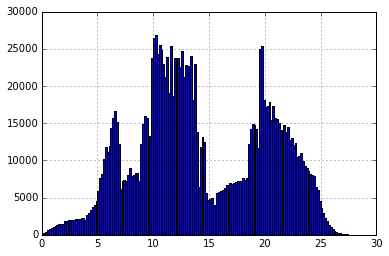

In [17]:
(ts_parsed/ttools.datetime.timedelta(hours=1)).hist(range=(0,30),bins=180)

In [19]:
set1 = set(gtfs_trip_ids)
set2 = set(bustime_trip_ids)

unmatched = set1.symmetric_difference(set2) # goes both ways
len(unmatched)

13728

In [20]:
# of trips by route with no data in BusTime set
pct_missing_by_route = trips.loc[unmatched].groupby('route_id').size()/trips.groupby('route_id').size()
pct_missing_by_route.sort(ascending=False)
pct_missing_by_route

route_id
S86      0.500000
S81      0.333333
S84      0.312500
S94      0.294118
S90      0.277778
S91      0.260000
S98      0.257143
S96      0.232143
S56      0.209402
S92      0.187500
BX20     0.181818
X17A     0.167883
X11      0.163265
Q26      0.145038
S55      0.142857
X3       0.138889
X2       0.134146
X19      0.130435
S54      0.129518
S42      0.129353
X21      0.119048
M98      0.118280
S89      0.114865
Q77      0.113943
X4       0.113924
X68      0.111111
X17J     0.110132
S93      0.107042
X9       0.106870
X37      0.105691
           ...   
QM1      0.007752
BXM7     0.007533
QM24     0.007299
Q37      0.006605
BM2      0.006494
Q66      0.005271
BXM6     0.004926
QM20     0.004717
QM4      0.004016
Q65      0.003864
QM6      0.003717
Q21      0.002941
BXM9     0.002762
Q53      0.002294
BM4           NaN
BXM18         NaN
Q104          NaN
Q35           NaN
Q70           NaN
QM10          NaN
QM12          NaN
QM15          NaN
QM16          NaN
QM17          NaN
Q

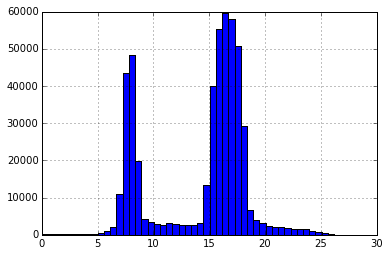

In [21]:
stop_hour = stop_times.reset_index().set_index('trip_id')['arrival_time'].apply(ttools.parseTime)/ttools.datetime.timedelta(hours=1)
stop_hour.loc[unmatched].hist(bins=48)

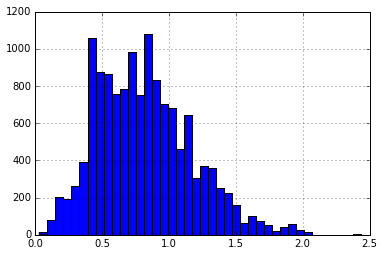

In [28]:
# check distribution of length of missing trips
pd.Series(stop_hour.loc[unmatched].groupby(level=0).max() - stop_hour.loc[unmatched].groupby(level=0).min()).hist(bins=40)

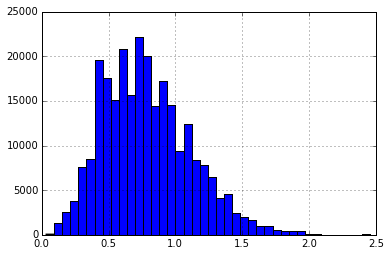

In [27]:
# compare to all scheduled trips
pd.Series(stop_hour.groupby(level=0).max() - stop_hour.groupby(level=0).min()).hist(bins=40)

## Analyze expected trip data-density, but agnostic to trip_id
First, plot how many vehicles are scheduled to be on an active trip, throughout the day.

In [91]:
start_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).min()).apply(np.floor).astype(int)
end_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).max()).apply(np.floor).astype(int)

In [92]:
time_bin_matrix = np.zeros((len(start_bins),max(end_bins)+1))
counter = 0
for i,v_start in start_bins.iteritems():
    v_end = end_bins.loc[i]
    time_bin_matrix[counter,v_start:v_end] = 1
    counter += 1

Now do the same from the BusTime data.  Danger - lots of vehicles may be recorded data despite no active trip.

In [72]:
ts_parsed.head()

route        trip_id                         trip_date   vehicle_id   
MTA NYCT_B1  UP_A5-Weekday-SDon-009800_B1_1  2015-01-06  MTA NYCT_4857   01:43:21
                                                         MTA NYCT_4857   01:44:24
                                                         MTA NYCT_4857   01:45:27
                                                         MTA NYCT_4857   01:46:31
                                                         MTA NYCT_4857   01:47:34
Name: timestamp, dtype: timedelta64[ns]

In [79]:
start_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).min()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
end_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).max()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)

In [80]:
time_bin_matrix_bustime = np.zeros((len(start_bins_bustime),max(end_bins_bustime)+1))
counter = 0
for i,v_start in start_bins_bustime.iteritems():
    v_end = end_bins_bustime.loc[i]
    time_bin_matrix_bustime[counter,v_start:v_end] = 1
    counter += 1

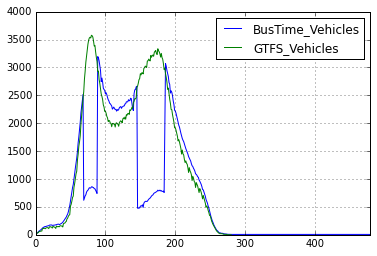

In [98]:
pd.DataFrame(time_bin_matrix_bustime.sum(axis=0),columns=['BusTime_Vehicles']).join(pd.Series(time_bin_matrix.sum(axis=0),name='GTFS_Vehicles')).plot()